In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics.pairwise import cosine_similarity
from imblearn.over_sampling import SMOTE


In [3]:

# Load the data
data = pd.read_csv('Maternal Health Risk Data Set.csv')


In [4]:
# Data Exploration
print(data.head())
print(data.info())
print(data.describe())
print(data.dtypes)
print(data.isnull().sum())


   Age  SystolicBP  DiastolicBP    BS  BodyTemp  HeartRate  RiskLevel
0   25         130           80  15.0      98.0         86  high risk
1   35         140           90  13.0      98.0         70  high risk
2   29          90           70   8.0     100.0         80  high risk
3   30         140           85   7.0      98.0         70  high risk
4   35         120           60   6.1      98.0         76   low risk
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1014 entries, 0 to 1013
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          1014 non-null   int64  
 1   SystolicBP   1014 non-null   int64  
 2   DiastolicBP  1014 non-null   int64  
 3   BS           1014 non-null   float64
 4   BodyTemp     1014 non-null   float64
 5   HeartRate    1014 non-null   int64  
 6   RiskLevel    1014 non-null   object 
dtypes: float64(2), int64(4), object(1)
memory usage: 55.6+ KB
None
               Age   Systoli

<Figure size 1500x1000 with 0 Axes>

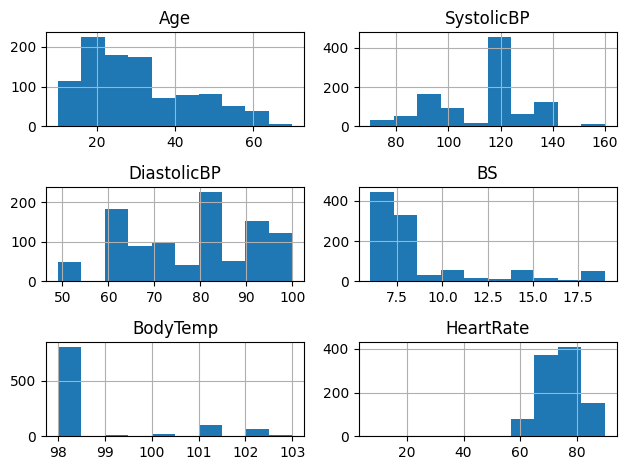

In [5]:
# Visualize the distribution of features
plt.figure(figsize=(15, 10))
data.hist()
plt.tight_layout()
plt.show()


In [6]:
 #Check the distribution of the target variable
print(data['RiskLevel'].value_counts(normalize=True))


RiskLevel
low risk     0.400394
mid risk     0.331361
high risk    0.268245
Name: proportion, dtype: float64


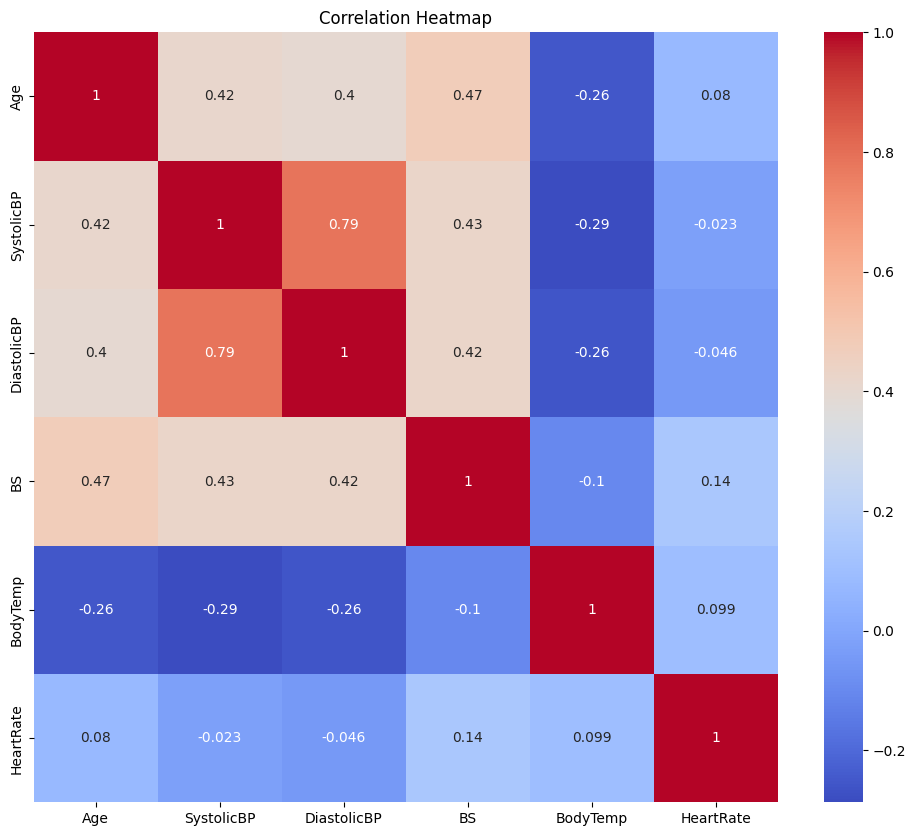

In [7]:
# Visualizations
numeric_columns = data.select_dtypes(include=[np.number]).columns
plt.figure(figsize=(12, 10))
sns.heatmap(data[numeric_columns].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()


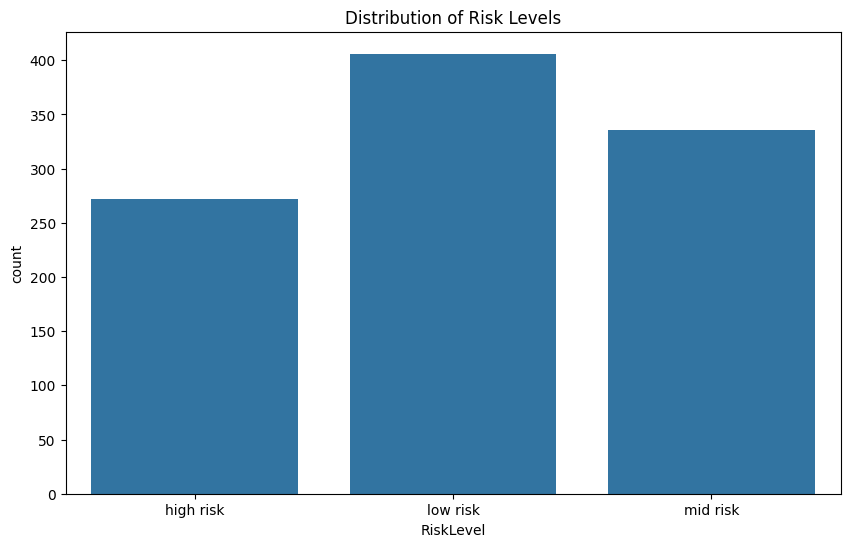

In [8]:
plt.figure(figsize=(10, 6))
sns.countplot(x='RiskLevel', data=data)
plt.title('Distribution of Risk Levels')
plt.show()

In [9]:
# Preprocessing
# Encode the target variable
data['RiskLevel'] = pd.Categorical(data['RiskLevel']).codes


In [10]:
# Separate features and target
X = data.drop('RiskLevel', axis=1)
y = data['RiskLevel']

In [11]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



In [12]:
# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [13]:
 #Handle class imbalance
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)



In [14]:
# Calculate cosine similarity
similarity_matrix = cosine_similarity(X_train_resampled)

# Function to find similar patients
def find_similar_patients(patient_index, top_n=5):
    patient_similarities = similarity_matrix[patient_index]
    similar_indices = patient_similarities.argsort()[::-1][1:top_n+1]
    similar_patients = X_train.iloc[similar_indices]
    similarities = patient_similarities[similar_indices]
    return similar_patients, similarities


In [15]:
# Models with hyperparameter grids
models = [
    ('Logistic Regression', LogisticRegression(random_state=42),
     {'C': [0.1, 1, 10], 'penalty': ['l2']}),
    ('Random Forest', RandomForestClassifier(random_state=42),
     {'n_estimators': [100, 200], 'max_depth': [None, 10, 20]}),
    ('Gradient Boosting', GradientBoostingClassifier(random_state=42),
     {'n_estimators': [100, 200], 'learning_rate': [0.01, 0.1]}),
    ('SVM', SVC(random_state=42, probability=True),
     {'C': [0.1, 1, 10], 'kernel': ['rbf', 'linear']}),
    ('KNN', KNeighborsClassifier(),
     {'n_neighbors': [3, 5, 7], 'weights': ['uniform', 'distance']}),
    ('Naive Bayes', GaussianNB(), {}),
    ('XGBoost', XGBClassifier(random_state=42),
     {'n_estimators': [100, 200], 'learning_rate': [0.01, 0.1], 'max_depth': [3, 5]})
]

In [16]:
# Neural Network
def create_nn_model(input_shape):
    model = Sequential([
        Dense(64, activation='relu', input_shape=input_shape),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dropout(0.3),
        Dense(16, activation='relu'),
        Dense(3, activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model



Training Logistic Regression...
Best parameters: {'C': 0.1, 'penalty': 'l2'}
Cross-validation Accuracy: 0.6135
Test Accuracy: 0.6404
Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.85      0.76        47
           1       0.62      0.81      0.71        80
           2       0.61      0.33      0.43        76

    accuracy                           0.64       203
   macro avg       0.64      0.66      0.63       203
weighted avg       0.63      0.64      0.61       203



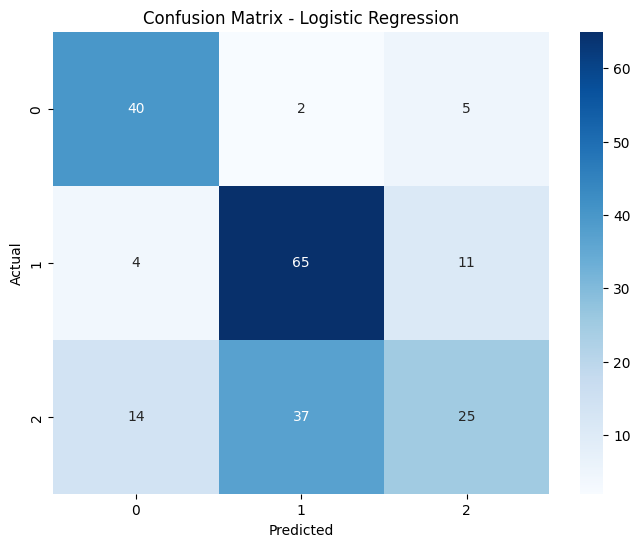


Training Random Forest...
Best parameters: {'max_depth': 20, 'n_estimators': 200}
Cross-validation Accuracy: 0.8548
Test Accuracy: 0.8128
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.85      0.85        47
           1       0.88      0.74      0.80        80
           2       0.74      0.87      0.80        76

    accuracy                           0.81       203
   macro avg       0.82      0.82      0.82       203
weighted avg       0.82      0.81      0.81       203



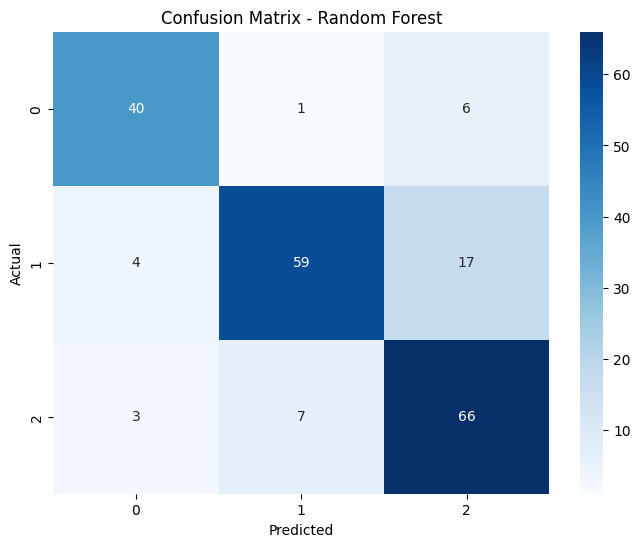


Training Gradient Boosting...
Best parameters: {'learning_rate': 0.1, 'n_estimators': 200}
Cross-validation Accuracy: 0.8446
Test Accuracy: 0.7734
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.85      0.85        47
           1       0.77      0.76      0.77        80
           2       0.73      0.74      0.73        76

    accuracy                           0.77       203
   macro avg       0.78      0.78      0.78       203
weighted avg       0.77      0.77      0.77       203



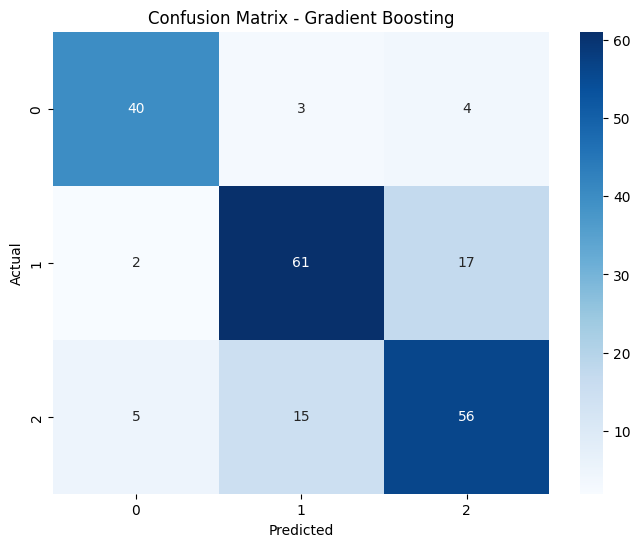


Training SVM...
Best parameters: {'C': 10, 'kernel': 'rbf'}
Cross-validation Accuracy: 0.7178
Test Accuracy: 0.6798
Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.81      0.79        47
           1       0.64      0.76      0.70        80
           2       0.66      0.51      0.58        76

    accuracy                           0.68       203
   macro avg       0.69      0.69      0.69       203
weighted avg       0.68      0.68      0.67       203



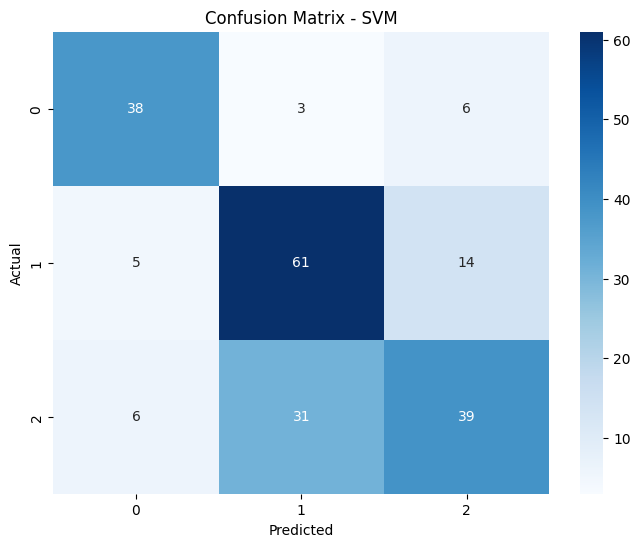


Training KNN...
Best parameters: {'n_neighbors': 7, 'weights': 'distance'}
Cross-validation Accuracy: 0.8333
Test Accuracy: 0.8079
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.87      0.86        47
           1       0.82      0.76      0.79        80
           2       0.77      0.82      0.79        76

    accuracy                           0.81       203
   macro avg       0.81      0.82      0.82       203
weighted avg       0.81      0.81      0.81       203



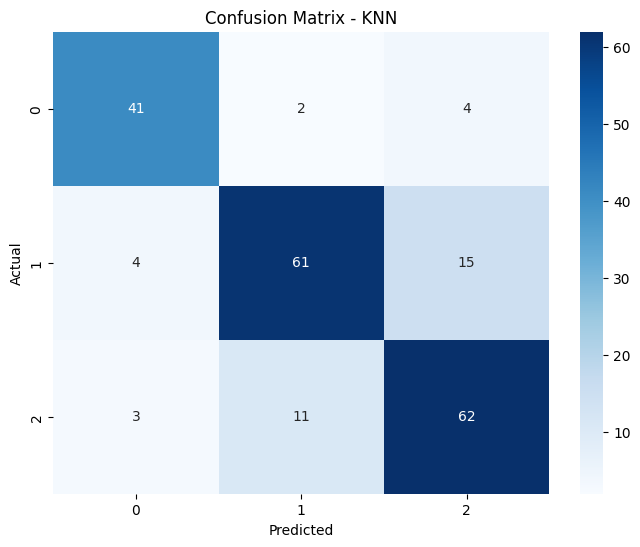


Training Naive Bayes...
Cross-validation Accuracy: 0.5940
Test Accuracy: 0.6108
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.79      0.80        47
           1       0.55      0.91      0.69        80
           2       0.56      0.18      0.28        76

    accuracy                           0.61       203
   macro avg       0.64      0.63      0.59       203
weighted avg       0.62      0.61      0.56       203



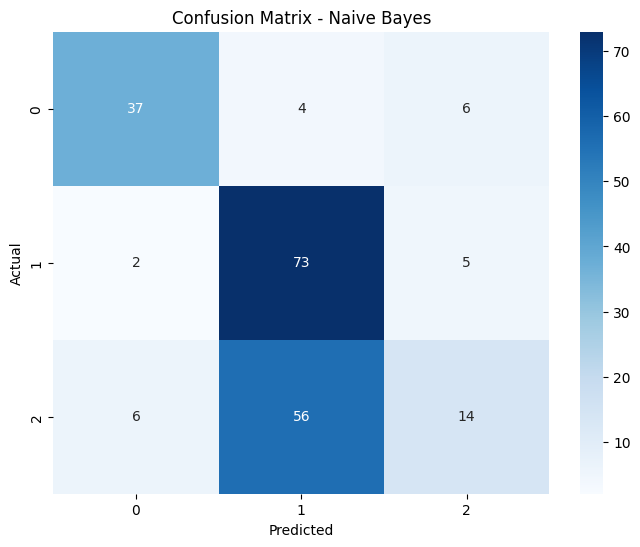


Training XGBoost...
Best parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}
Cross-validation Accuracy: 0.8446
Test Accuracy: 0.8227
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.85      0.85        47
           1       0.84      0.81      0.83        80
           2       0.78      0.82      0.80        76

    accuracy                           0.82       203
   macro avg       0.83      0.83      0.83       203
weighted avg       0.82      0.82      0.82       203



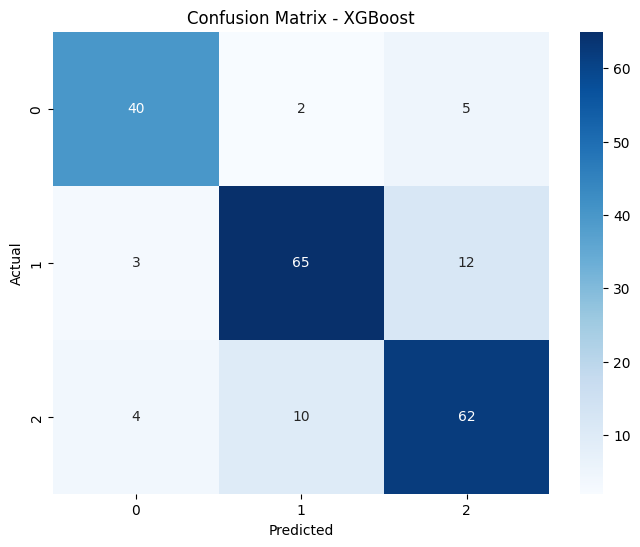

In [17]:
# Train and evaluate models with cross-validation and hyperparameter tuning
results = []
cv = KFold(n_splits=5, shuffle=True, random_state=42)

for name, model, param_grid in models:
    print(f"\nTraining {name}...")
    
    if param_grid:
        grid_search = GridSearchCV(model, param_grid, cv=cv, scoring='accuracy', n_jobs=-1)
        grid_search.fit(X_train_resampled, y_train_resampled)
        
        best_model = grid_search.best_estimator_
        cv_score = grid_search.best_score_
        
        print(f"Best parameters: {grid_search.best_params_}")
    else:
        cv_scores = cross_val_score(model, X_train_resampled, y_train_resampled, cv=cv, scoring='accuracy')
        cv_score = np.mean(cv_scores)
        best_model = model.fit(X_train_resampled, y_train_resampled)
    
    y_pred = best_model.predict(X_test_scaled)
    test_accuracy = accuracy_score(y_test, y_pred)
    
    results.append((name, cv_score, test_accuracy, best_model))
    
    print(f"Cross-validation Accuracy: {cv_score:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {name}')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()


In [18]:
# Neural Network
nn_model = create_nn_model((X_train_scaled.shape[1],))
history = nn_model.fit(X_train_resampled, y_train_resampled,
                       epochs=100, batch_size=32, validation_split=0.2, verbose=0)

y_pred = np.argmax(nn_model.predict(X_test_scaled), axis=-1)
nn_accuracy = accuracy_score(y_test, y_pred)
results.append(('Neural Network', history.history['val_accuracy'][-1], nn_accuracy, nn_model))

print("\nNeural Network Results:")
print(f"Validation Accuracy: {history.history['val_accuracy'][-1]:.4f}")
print(f"Test Accuracy: {nn_accuracy:.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred))

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

Neural Network Results:
Validation Accuracy: 0.6888
Test Accuracy: 0.6700
Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.89      0.82        47
           1       0.60      0.88      0.71        80
           2       0.77      0.32      0.45        76

    accuracy                           0.67       203
   macro avg       0.71      0.69      0.66       203
weighted avg       0.70      0.67      0.64       203



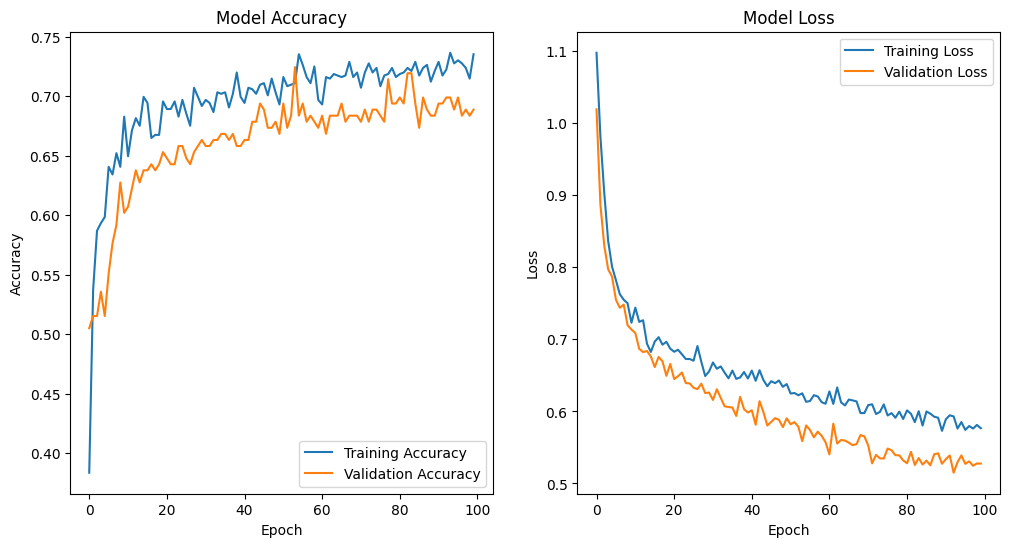

In [19]:
# Plot training history
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
# Plot training history
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [20]:
# Compare model performances
results.sort(key=lambda x: x[2], reverse=True)
for name, cv_accuracy, test_accuracy, _ in results:
    print(f"{name}: CV Accuracy = {cv_accuracy:.4f}, Test Accuracy = {test_accuracy:.4f}")

XGBoost: CV Accuracy = 0.8446, Test Accuracy = 0.8227
Random Forest: CV Accuracy = 0.8548, Test Accuracy = 0.8128
KNN: CV Accuracy = 0.8333, Test Accuracy = 0.8079
Gradient Boosting: CV Accuracy = 0.8446, Test Accuracy = 0.7734
SVM: CV Accuracy = 0.7178, Test Accuracy = 0.6798
Neural Network: CV Accuracy = 0.6888, Test Accuracy = 0.6700
Logistic Regression: CV Accuracy = 0.6135, Test Accuracy = 0.6404
Naive Bayes: CV Accuracy = 0.5940, Test Accuracy = 0.6108


In [28]:
# Select the best model
best_name, _, _, best_model = results[0]
print(f"\nBest Model: {best_name}")

def predict_risk(model, input_data, scaler):
    # Scale the input data
    scaled_input = scaler.transform(input_data.reshape(1, -1))
    


Best Model: XGBoost
